# Projeto de redes convolucionais
Aluno: Paulo Victor Fonseca Sousa

Matricula:211043718

Github:PauloVictorFS

## Introdução
O projeto a seguir tem como objetivo explorar o aprendizado de máquina aplicado à redes convolucionais, e explicar o funcionamento de uma CNN (Convolutional Neural Net), ou Rede Neural Convolucional, e aplicar ao reconhecimento de imagens:

Critérios do projeto:
Propósito: O projeto tem como propósito principal aplicar ao reconhecimento de imagens o assunto de redes convolucionais

Tema Abordado na Lição: O projeto está alinhado com os conceitos e técnicas apresentados na lição do Fastai relacionada a redes convolucionais

Dado Coerente com o Tema: Os dados utilizados para treinar e testar o modelo são imagens de computadores e notebooks. Isso está em conformidade com a tarefa

Caracterização do Dado: Os dados são coletados da web usando a API do DuckDuckGo e passam por um processo de verificação manual de qualidade antes de serem usados para treinamento do modelo. O fluxo de aquisição e pré-processamento dos dados será detalhado.

Organização: O projeto é organizado em células de código que executam tarefas específicas, desde a aquisição de dados até a criação, treinamento e avaliação do modelo. Isso proporciona uma estrutura clara para compreender o fluxo de trabalho. Cada célula será explicada de forma detalhada

Jupyter: O projeto é elaborado usando um ambiente Jupyter Notebook, o que permite documentar as etapas do projeto e executar código interativamente.



##  Configurando o Ambiente
Nesta parte é instalado dois pacotes Python, "duckduckgo_search" e "fastai", usando o comando pip install. Esses pacotes são necessários para as tarefas subsequentes no projeto. Também é realizado a importação de funções do pacote "duckduckgo_search" e definido uma função chamada search_images. Essa função permite buscar e coletar URLs de imagens relacionadas a um termo específico usando a API do DuckDuckGo.

In [5]:
# Importando Bibliotecas necessarias
import numpy as np 
import pandas as pd
!pip install -Uqq duckduckgo_search
!pip install -Uqq fastai

from duckduckgo_search import ddg_images
from fastcore.all import *
from fastai.vision.all import *


def search_images(term, max_images=300): return L(ddg_images(term, max_results=max_images)).itemgot('image')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Baixando e Analisando as Imagens
Nestas células, são realizados os downloads de uma única imagem de um "Notebook" e de um "Computador" usando a função download_url e exibido essas imagens em miniatura. Isso é realizado para garantir que a função está funcionando conforme o esperado. Após isso serão baixadas as imagens e  definido um bloco de dados (DataBlock) para organizar os dados de imagem. Isso envolve a definição de blocos de entrada (imagem) e saída (categoria), bem como as transformações de dados e a divisão dos dados em conjuntos de treinamento e validação.

Além disso, é exibido um lote de imagens dos conjuntos de dados de treinamento e validação usando a função show_batch. Isso ajuda a entender como os dados estão organizados e visualmente inspecionar as imagens.

/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:40: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")


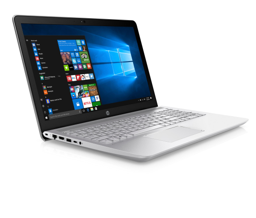

In [6]:
from fastai.vision.all import *
from fastdownload import download_url

download_url(search_images('Notebook', max_images=1)[0], 'Notebook.jpg', show_progress=False)
Image.open('Notebook.jpg').to_thumb(256,256)

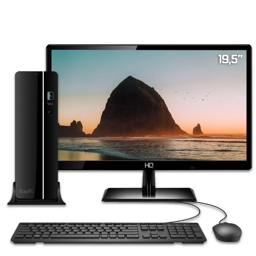

In [7]:
from fastai.vision.all import *
from fastdownload import download_url

download_url(search_images('Computador', max_images=1)[0], 'Computador.jpg', show_progress=False)
Image.open('Computador.jpg').to_thumb(256,256)

In [8]:
searches = ' Notebook','Computador'
path = Path('Notebook ou Computador')
from time import sleep

# Download e resize das imagens
for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o}'))
    sleep(1)  
    resize_images(path/o, max_size=400, dest=path/o)

In [9]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

2

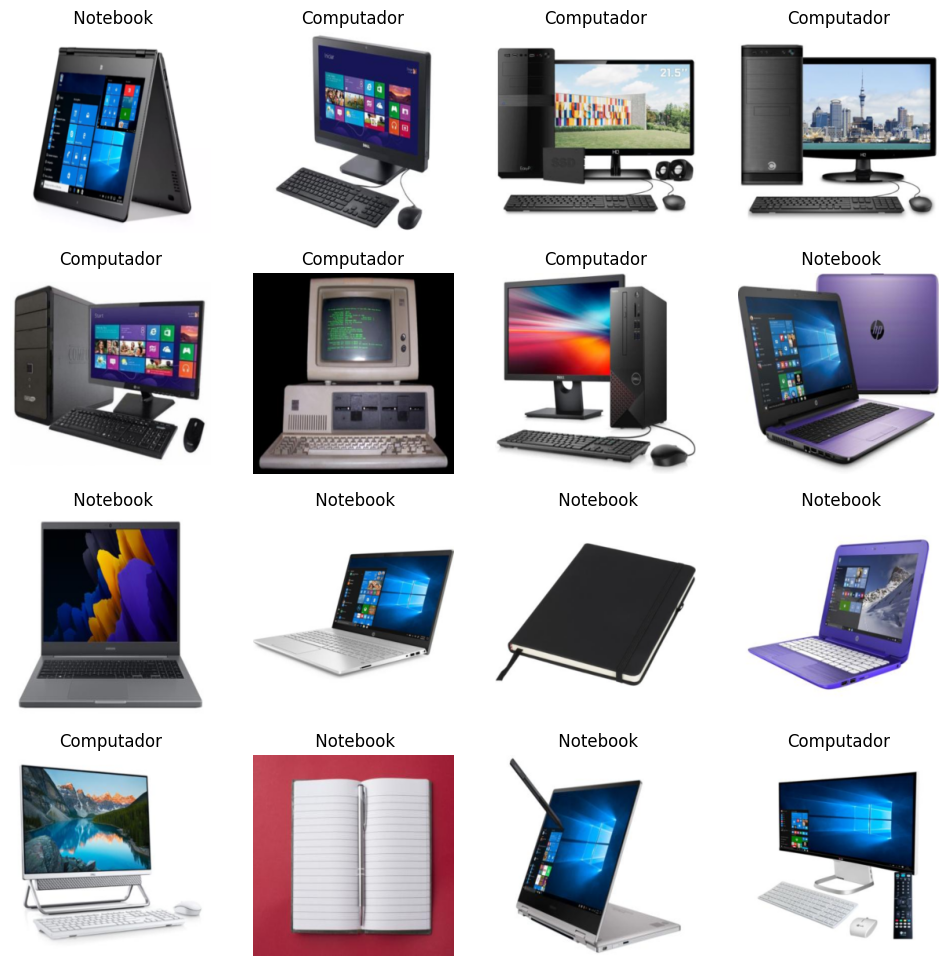

In [10]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(256, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=16)


# Convolução

A convolução pode ser entendida como um método matemático que combina duas funções para criar uma terceira, calculando a média ponderada do produto dessas funções ao longo de diferentes posições. Quando aplicado ao processamento de imagens, esse conceito envolve sobrepor um filtro à imagem, realizando uma operação de multiplicação ponto a ponto entre o filtro e a imagem. Essa multiplicação é feita em diferentes regiões da imagem, variando a sobreposição por meio de deslocamento, o que resulta em uma nova imagem transformada. A escolha e configuração do filtro podem produzir efeitos diversos, como desfocagem, ajuste de cores, detecção de bordas e outras manipulações visuais. No exemplo mencionado, um filtro foi manualmente projetado para reduzir a saturação geral da imagem, ao mesmo tempo que realça a presença da cor vermelha.

A célula Abaixo carrega uma imagem, redimensiona para 32x32 pixels, converte para um array NumPy e exibe a imagem original e a imagem redimensionada lado a lado usando a biblioteca Matplotlib.

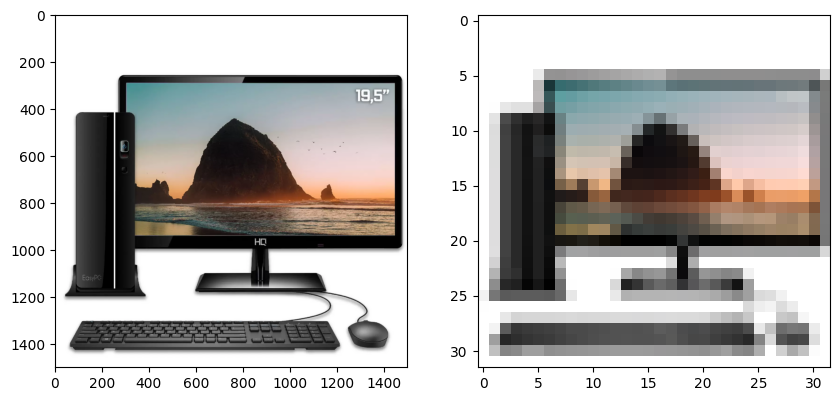

In [11]:
im = Image.open(r'/kaggle/working/Computador.jpg')
newsize = (32, 32)
im2 = im.resize(newsize)
from matplotlib import pyplot as plt
img = np.asarray(im2)
# Converter imagem para array NumPy
original = np.asarray(im, dtype=np.uint8)
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(original)
axs[1].imshow(img)

A célula abaixo define um filtro 3x3x3 (3 dimensões para as cores RGB) com valores específicos para dessaturar a imagem, mantendo uma ênfase na cor verde. Esse filtro será aplicado à imagem na célula 4.

In [12]:
filter_1 = np.zeros((3,3,3), dtype=float)

filter_1[1][1][0] = 0.4
filter_1[1][1][1] = 0.4
filter_1[1][1][2] = 0.3

A célula abaixo exibe o filtro criado na célula acima usando a Matplotlib

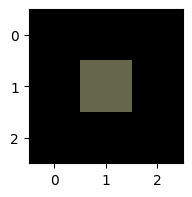

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(2,2))
ax.imshow(filter_1)


Na célula abaixo, um novo array img_2 é inicializado e preenchido multiplicando cada canal de cor da imagem redimensionada (img) pelos valores correspondentes do filtro. O resultado é uma nova imagem (img_2) que destaca a cor vermelha e dessatura as demais cores.

In [14]:
img_2 = np.zeros((32,32,3), dtype=float)

for i in range(32):
    for j in range(32):
        img_2[i][j][0] = img[:,:,0][i][j] * 0.4
        img_2[i][j][1] = img[:,:,1][i][j] * 0.3
        img_2[i][j][2] = img[:,:,2][i][j] * 0.3

img_2 = np.asarray(img_2, dtype=np.uint8)
np.shape(img_2)

(32, 32, 3)

A célula abaixo exibe a imagem original (img) e a imagem processada (img_2) lado a lado para comparar os efeitos da aplicação do filtro. Isso ajuda a visualizar como a convolução com o filtro modificado afeta a representação da imagem original.






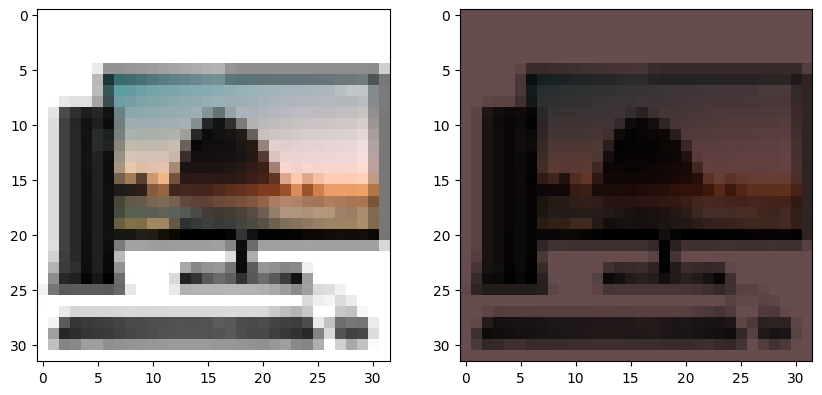

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(img)
axs[1].imshow(img_2)

## Dropout

A técnica de dropout é uma estratégia de regularização frequentemente empregada em redes neurais, especialmente em redes convolucionais, com o objetivo de mitigar o overfitting. O overfitting ocorre quando a rede neural aprende padrões específicos dos dados de treinamento que não são generalizáveis para novos dados. O dropout aborda esse problema desativando aleatoriamente um subconjunto de neurônios durante o treinamento, o que impede que a rede se torne excessivamente dependente de neurônios específicos e, assim, melhora a capacidade de generalização.

A função show_img na célula Abaixo é uma função que exibe uma imagem. Ela usa a biblioteca Matplotlib para mostrar uma imagem, definindo um título e desativando os eixos para melhor visualização.

In [16]:
def show_img(img, title="Image"):
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

A célula abaixo contém a função dropout_np, que implementa a técnica de dropout de forma manual usando a biblioteca NumPy. A função recebe uma imagem e um fator de dropout como entrada. Ela gera um tensor aleatório do mesmo formato que a imagem e cria uma máscara binária onde os valores são 1 se forem maiores que o fator de dropout e 0 caso contrário. A imagem original é então multiplicada por essa máscara, resultando em uma nova imagem onde parte dos pixels foi "desativada".

In [17]:
def dropout_np(img, factor=0.5):
    random_tensor = np.random.rand(*img.shape)
    dropout_mask = (random_tensor > factor).astype(np.uint8)
    return img * dropout_mask

Por fim, a função show_img é usada para exibir a imagem original com o título "Imagem Original". Em seguida, a função dropout_np é aplicada à imagem original com um fator de dropout de 0.5, e a imagem resultante é exibida com o título "Imagem Com Fator de Dropout = 0.5". Esse processo demonstra visualmente como o dropout pode afetar a representação da imagem, desativando alguns dos pixels durante o treinamento. O fator de dropout de 0.5 indica que, em média, metade dos neurônios será desativada durante o treinamento.

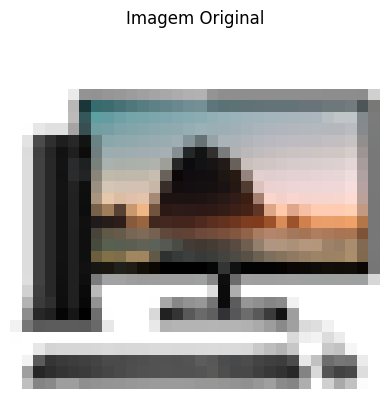

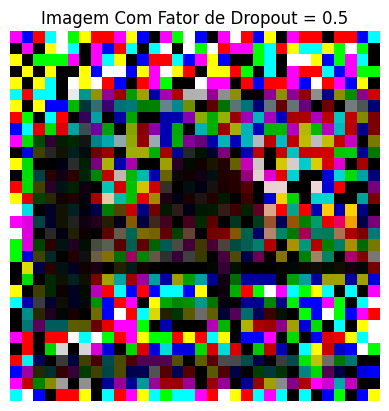

In [18]:
show_img(img, title="Imagem Original")

dropped_img = dropout_np(img)
show_img(dropped_img, title="Imagem Com Fator de Dropout = 0.5")

# Criação dos modelos

Nessa etapa serão criados 2 modelos, sendo um deles de CNN com a resnet50, por meio das funções-padrão do FastAi, E após isso um modelo manual.

## Modelo resnet50


In [24]:
learn = vision_learner(dls, resnet50)
learn.fine_tune(5)

epoch,train_loss,valid_loss,time
0,1.029616,0.227748,00:02


epoch,train_loss,valid_loss,time
0,0.249280,0.274197,00:02
1,0.167192,0.330156,00:02
2,0.126651,0.145807,00:02
3,0.101993,0.077380,00:02
4,0.083964,0.074722,00:02


## Modelo Manual

In [30]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

In [31]:
simple_cnn = sequential(
    conv(3 ,4),
    conv(4 ,8),
    conv(8 ,16),
    conv(16,32),
    conv(32,2, act=False),
    Flatten(),
    nn.Dropout(0.2),
)

In [32]:
learn2 = Learner(dls, simple_cnn)

In [34]:
learn2.fine_tune(15)

epoch,train_loss,valid_loss,time
0,2.480388,1.756695,00:01


epoch,train_loss,valid_loss,time
0,2.283033,1.751026,00:01
1,2.385371,1.717976,00:01
2,2.311609,1.698501,00:01
3,2.337534,1.694421,00:01
4,2.344527,1.722441,00:01
5,2.378676,1.688599,00:01
6,2.376864,1.680094,00:01
7,2.318463,1.696451,00:01
8,2.288433,1.699187,00:01
9,2.293611,1.693422,00:01


## Deploy Para o Hugging face


Clique nesses links para acessar o hugging face dos modelos treinados

[resnet50](https://huggingface.co/spaces/Srpaulo122/Notebook_Computer_resnet50?logs=build)

[Manual](https://huggingface.co/spaces/Srpaulo122/Notebook_Computer_Manual/tree/main)

In [27]:
learn.export('model.pkl')


In [36]:
learn2.export('model2.pkl')